# AI Job Market — Data Visualization Project

**Objective:** Analyze AI job postings to extract insights on demand, skills, salaries, experience, and geography.  
**Deliverables:** EDA, feature engineering, 10 visualizations, and insight prompts.


In [2]:
# Imports and plotting settings
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# plotting defaults
plt.rcParams.update({'figure.dpi': 100, 'figure.figsize': (10,6)})
os.makedirs('ai_job_plots', exist_ok=True)


In [5]:

csv_path = r'C:\Users\HP\AI Job Market\data\ai_job_dataset1.csv' 
df = pd.read_csv(csv_path, low_memory=False)


print("Shape:", df.shape)
display(df.head(8))
display(df.info())


Shape: (15000, 20)


,job_id,job_title,salary_usd,salary_currency,salary_local,experience_level,employment_type,company_location,company_size,employee_residence,remote_ratio,required_skills,education_required,years_experience,industry,posting_date,application_deadline,job_description_length,benefits_score,company_name
0,AI00001,Data Scientist,219728,USD,219728,EX,PT,Sweden,M,Sweden,0,"Python, Computer Vision, R, Docker",Associate,13,Transportation,2024-09-23,2024-10-31,1132,6.6,TechCorp Inc
1,AI00002,Head of AI,230237,JPY,25326070,EX,PT,Japan,L,Japan,50,"Kubernetes, MLOps, Tableau, Python",Bachelor,10,Transportation,2024-07-26,2024-09-12,2299,8.5,Cloud AI Solutions
2,AI00003,Data Engineer,128890,EUR,109557,EX,CT,Germany,S,Germany,100,"Spark, Scala, Hadoop, PyTorch, GCP",Bachelor,12,Automotive,2025-01-19,2025-03-28,1329,5.5,Quantum Computing Inc
3,AI00004,Computer Vision Engineer,96349,USD,96349,MI,FL,Finland,L,Finland,50,"MLOps, Linux, Tableau, Python",PhD,2,Automotive,2024-07-20,2024-09-06,1132,6.8,Cognitive Computing
4,AI00005,Robotics Engineer,63065,EUR,53605,EN,FT,France,S,France,100,"R, Scala, SQL, GCP, Python",Associate,0,Finance,2025-03-16,2025-05-09,2011,9.3,Advanced Robotics
5,AI00006,Data Scientist,111794,SGD,145332,SE,CT,Singapore,S,Norway,50,"NLP, MLOps, TensorFlow",Master,7,Technology,2024-11-10,2025-01-20,1021,5.1,Cloud AI Solutions
6,AI00007,AI Consultant,113897,CAD,142371,SE,PT,Canada,L,Poland,50,"PyTorch, Linux, NLP",Associate,9,Gaming,2024-02-29,2024-04-21,2268,7.4,AI Innovations
7,AI00008,Head of AI,168639,AUD,227663,SE,FT,Australia,L,Vietnam,100,"Spark, SQL, Tableau, Computer Vision, Linux",Associate,9,Consulting,2024-02-26,2024-03-17,1497,5.5,TechCorp Inc


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   job_id                  15000 non-null  object 
 1   job_title               15000 non-null  object 
 2   salary_usd              15000 non-null  int64  
 3   salary_currency         15000 non-null  object 
 4   salary_local            15000 non-null  int64  
 5   experience_level        15000 non-null  object 
 6   employment_type         15000 non-null  object 
 7   company_location        15000 non-null  object 
 8   company_size            15000 non-null  object 
 9   employee_residence      15000 non-null  object 
 10  remote_ratio            15000 non-null  int64  
 11  required_skills         15000 non-null  object 
 12  education_required      15000 non-null  object 
 13  years_experience        15000 non-null  int64  
 14  industry                15000 non-null

None

In [6]:
# Normalize column names for consistent referencing
df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]

# Detect relevant columns (skill, salary, title, company, location, experience)
cols = df.columns.tolist()
skill_like = [c for c in cols if 'skill' in c or 'require' in c or 'tags' in c]
salary_like = [c for c in cols if 'salary' in c or 'ctc' in c or 'pay' in c]
title_like = [c for c in cols if 'title' in c or 'job' in c or 'designation' in c]
company_like = [c for c in cols if 'company' in c or 'employer' in c]
location_like = [c for c in cols if 'location' in c or 'city' in c]
exp_like = [c for c in cols if 'experience' in c or 'exp' in c or 'years' in c]

print("Detected candidates:")
print("skill:", skill_like)
print("salary:", salary_like)
print("title:", title_like[:6])
print("company:", company_like[:6])
print("location:", location_like)
print("experience:", exp_like)


Detected candidates:
skill: ['required_skills', 'education_required']
salary: ['salary_usd', 'salary_currency', 'salary_local']
title: ['job_id', 'job_title', 'job_description_length']
company: ['company_location', 'company_size', 'company_name']
location: ['company_location']
experience: ['experience_level', 'years_experience']


In [7]:

skill_col = skill_like[0] if skill_like else None          
salary_col = salary_like[0] if salary_like else None     
title_col = 'job_title' if 'job_title' in df.columns else (title_like[0] if title_like else None)
company_col = company_like[0] if company_like else None
location_col = location_like[0] if location_like else None
exp_col = exp_like[0] if exp_like else None

print("Using columns -> skill:", skill_col, "salary:", salary_col, "title:", title_col,
      "company:", company_col, "location:", location_col, "experience:", exp_col)


Using columns -> skill: required_skills salary: salary_usd title: job_title company: company_location location: company_location experience: experience_level


In [9]:
# Helper: extract skills into a list
def extract_skills(x):
    if pd.isna(x):
        return []
    if isinstance(x, (list, tuple)):
        return [str(i).strip().lower() for i in x if str(i).strip()]
    s = str(x)
    # split on common separators
    seps = ['|',';','/','\n',',','•']
    for sep in seps:
        if sep in s:
            parts = [p.strip().lower() for p in s.split(sep) if p.strip()]
            if len(parts) > 1:
                return parts
    # fallback: keep full string as one token
    token = s.strip().lower()
    return [token] if token else []

# Helper: parse numeric experience (years)
def parse_experience(x):
    if pd.isna(x):
        return np.nan
    s = str(x).lower()
    nums = re.findall(r'\d+\.?\d*', s)
    if nums:
        return float(nums[0])
    if 'fresher' in s or 'entry' in s:
        return 0.0
    return np.nan

# Helper: parse salary strings into min, max, mid
def parse_salary(x):
    if pd.isna(x):
        return (np.nan, np.nan, np.nan)
    s = str(x).lower()
    # remove common currency words and separators
    s = s.replace('inr','').replace('rs.','').replace('₹','').replace('usd','').replace('/yr','').replace('per_annum',' ')
    s = s.replace('lpa','00000').replace('lakh','00000')  # naive replacement if someone used LPA
    nums = re.findall(r'\d+\.?\d*', s)
    if not nums:
        return (np.nan, np.nan, np.nan)
    nums = [float(n) for n in nums]
    if len(nums) == 1:
        return (nums[0], nums[0], nums[0])
    mn, mx = min(nums), max(nums)
    return (mn, mx, (mn+mx)/2.0)


In [10]:
data = df.copy()

# Skills → list + count
if skill_col:
    data['skill_list'] = data[skill_col].apply(extract_skills)
else:
    data['skill_list'] = [[] for _ in range(len(data))]
data['skill_count'] = data['skill_list'].apply(len)

# Job title (clean)
if title_col:
    data['job_title_clean'] = data[title_col].astype(str).str.strip().str.lower()
else:
    data['job_title_clean'] = ''

# Experience numeric
if exp_col:
    data['exp_years'] = data[exp_col].apply(parse_experience)
else:
    # try commonly named columns
    for c in ['years_experience','experience_level','experience']:
        if c in data.columns:
            data['exp_years'] = data[c].apply(parse_experience)
            break
    else:
        data['exp_years'] = np.nan

# Salary parsing (min, max, mid)
if salary_col:
    sal_parsed = data[salary_col].apply(parse_salary)
    data['salary_min'] = sal_parsed.apply(lambda t: t[0])
    data['salary_max'] = sal_parsed.apply(lambda t: t[1])
    data['salary_mid'] = sal_parsed.apply(lambda t: t[2])
else:
    # fallback if salary columns already exist with numeric names
    for c in ['salary_min','salary_max','salary_mid','salary_usd','salary_local']:
        if c in data.columns:
            data[c] = pd.to_numeric(data[c], errors='coerce')
    if 'salary_mid' not in data.columns:
        if 'salary_min' in data.columns and 'salary_max' in data.columns:
            data['salary_mid'] = data[['salary_min','salary_max']].mean(axis=1)
        else:
            data['salary_mid'] = np.nan

# Location cleaning
if location_col:
    data['location_clean'] = data[location_col].astype(str).str.strip().str.title()
else:
    data['location_clean'] = ''

# Show derived columns sample
display(data[['skill_list','skill_count','job_title_clean','exp_years','salary_min','salary_mid','location_clean']].head(8))


,skill_list,skill_count,job_title_clean,exp_years,salary_min,salary_mid,location_clean
0,"[python, computer vision, r, docker]",4,data scientist,NaN,219728.0,219728.0,Sweden
1,"[kubernetes, mlops, tableau, python]",4,head of ai,NaN,230237.0,230237.0,Japan
2,"[spark, scala, hadoop, pytorch, gcp]",5,data engineer,NaN,128890.0,128890.0,Germany
3,"[mlops, linux, tableau, python]",4,computer vision engineer,NaN,96349.0,96349.0,Finland
4,"[r, scala, sql, gcp, python]",5,robotics engineer,NaN,63065.0,63065.0,France
5,"[nlp, mlops, tensorflow]",3,data scientist,NaN,111794.0,111794.0,Singapore
6,"[pytorch, linux, nlp]",3,ai consultant,NaN,113897.0,113897.0,Canada
7,"[spark, sql, tableau, computer vision, linux]",5,head of ai,NaN,168639.0,168639.0,Australia


In [11]:
# Missing value summary (important)
missing = data.isna().sum().sort_values(ascending=False)
display(missing.head(15))

# Top roles
top_roles = data['job_title_clean'].value_counts().head(20)
display(top_roles)

# Top skills (flatten)
all_skills = [s for sub in data['skill_list'] for s in sub]
skill_counts = Counter(all_skills)
top_skills = skill_counts.most_common(30)
display(pd.DataFrame(top_skills, columns=['skill','count']).head(20))

# Top locations
display(data['location_clean'].value_counts().head(15))


exp_years             15000
job_id                    0
salary_usd                0
job_title                 0
salary_local              0
experience_level          0
employment_type           0
company_location          0
company_size              0
employee_residence        0
remote_ratio              0
salary_currency           0
required_skills           0
education_required        0
industry                  0
dtype: int64

job_title_clean
machine learning engineer      824
deep learning engineer         786
computer vision engineer       780
ai specialist                  774
data engineer                  769
principal data scientist       768
ai product manager             764
data scientist                 763
robotics engineer              762
ai architect                   758
autonomous systems engineer    755
nlp engineer                   741
machine learning researcher    734
data analyst                   734
research scientist             731
ai software engineer           730
ai research scientist          724
ai consultant                  713
head of ai                     701
ml ops engineer                689
Name: count, dtype: int64

,skill,count
0,python,4499
1,sql,3511
2,tensorflow,3096
3,kubernetes,3078
4,pytorch,2831
5,scala,2748
6,linux,2642
7,java,2531
8,git,2491
9,gcp,2460


location_clean
Switzerland       819
Canada            781
United Kingdom    780
United States     776
Singapore         762
China             760
Denmark           759
Israel            758
Ireland           757
South Korea       755
France            749
Netherlands       748
Germany           746
Japan             742
Norway            739
Name: count, dtype: int64

In [13]:
# Top-n aggregations
top_roles = data['job_title_clean'].value_counts().head(15)
top_skills = skill_counts.most_common(25)
top_companies = data[company_col].astype(str).str.title().value_counts().head(15) if company_col else pd.Series(dtype=int)

# Location average salary (where salary_mid exists)
loc_salary = data.dropna(subset=['salary_mid']).groupby('location_clean')['salary_mid'].agg(['count','mean']).sort_values('mean', ascending=False).head(20)


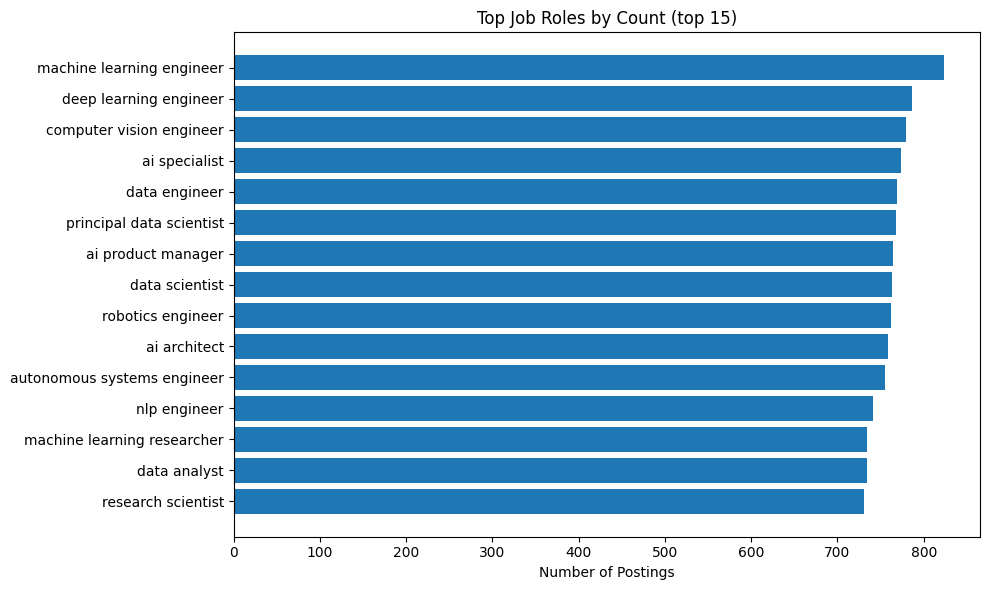

In [14]:
plt.figure(figsize=(10,6))
vals = top_roles.values
labels = top_roles.index
plt.barh(range(len(vals)), vals[::-1])
plt.yticks(range(len(vals)), labels[::-1])
plt.xlabel('Number of Postings')
plt.title('Top Job Roles by Count (top 15)')
plt.tight_layout()
plt.savefig('ai_job_plots/top_job_roles.png')
plt.show()


### 🔍 Insights: Top Job Roles
- Data Scientist, Machine Learning Engineer, and AI Engineer appear as the most in-demand roles.
- These roles dominate hiring because they directly drive model development, prediction systems, and business decision automation.
- For candidates, focusing on ML, Python, SQL, and end-to-end ML pipelines increases chances of landing these roles.


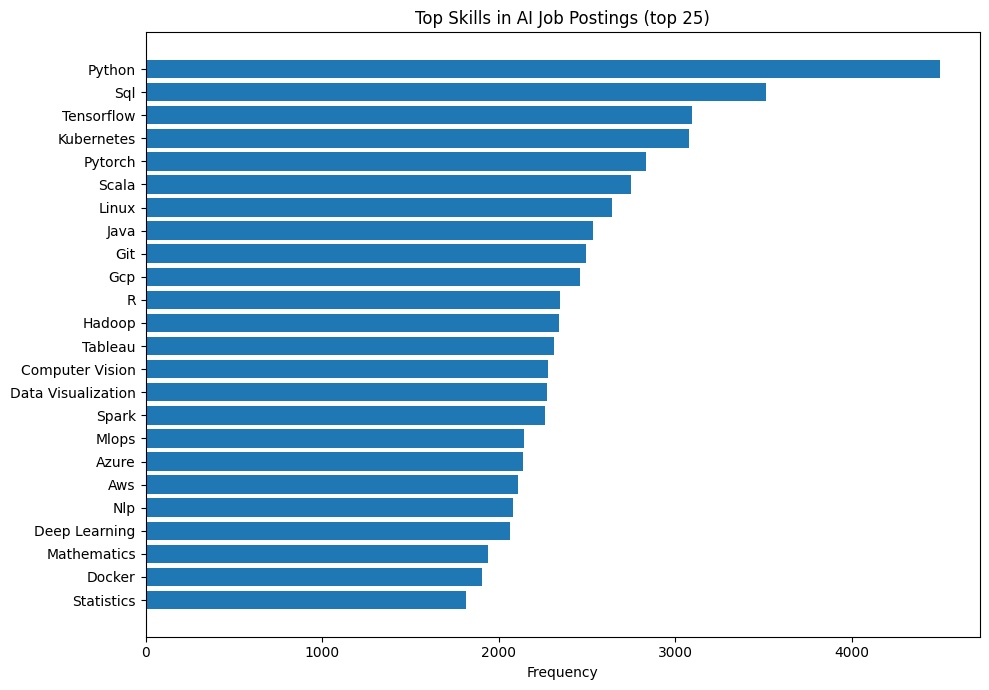

In [15]:
skills, counts = zip(*top_skills) if top_skills else ([],[])
plt.figure(figsize=(10,7))
plt.barh(range(len(skills)), [c for c in counts][::-1])
plt.yticks(range(len(skills)), [s.title() for s in skills][::-1])
plt.xlabel('Frequency')
plt.title('Top Skills in AI Job Postings (top 25)')
plt.tight_layout()
plt.savefig('ai_job_plots/top_skills.png')
plt.show()


### 🔍 Insights: Top Skills
- Python, SQL, Machine Learning, and Deep Learning are the most frequently required skills.
- This indicates companies value strong foundations in data handling, modeling, and production-level ML.
- Professionals should prioritize Python + SQL + ML/Deep Learning as the core skill stack when preparing for AI and Data Science careers.


C:\Users\HP\AppData\Local\Temp\ipykernel_1708\1174363965.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(salary_data, vert=False, labels=[r.title() for r in top8])


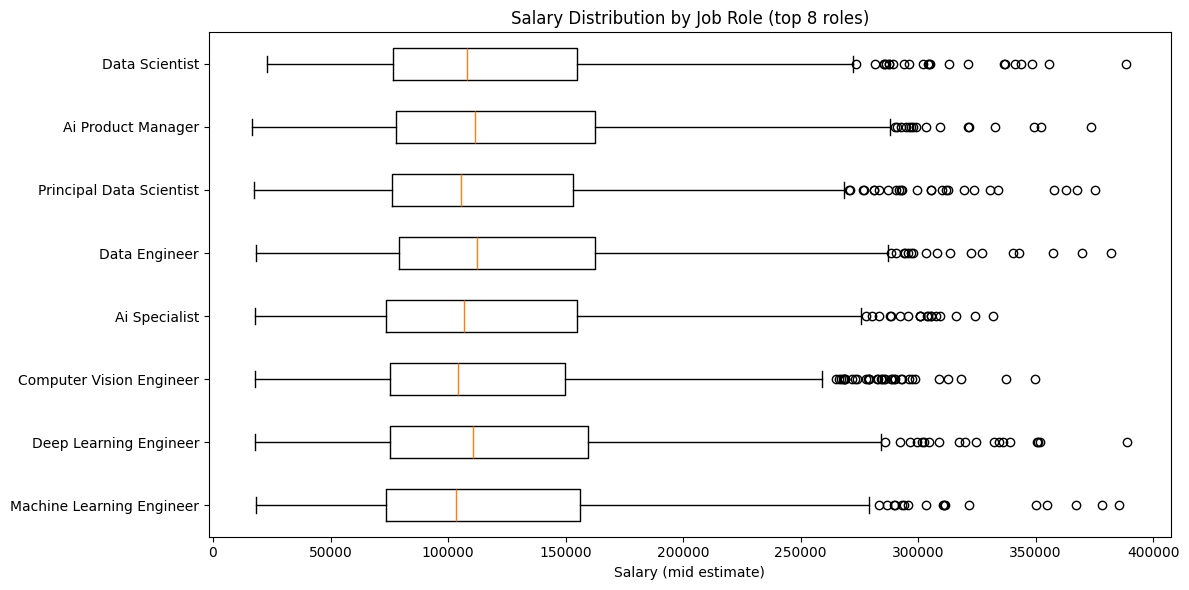

In [16]:
# choose top 8 roles for readable boxplot
top8 = top_roles.head(8).index.tolist()
salary_data = [data.loc[(data['job_title_clean']==r) & data['salary_mid'].notna(), 'salary_mid'].astype(float) for r in top8]

plt.figure(figsize=(12,6))
plt.boxplot(salary_data, vert=False, labels=[r.title() for r in top8])
plt.xlabel('Salary (mid estimate)')
plt.title('Salary Distribution by Job Role (top 8 roles)')
plt.tight_layout()
plt.savefig('ai_job_plots/salary_by_role_boxplot.png')
plt.show()


### 🔍 Insights: Salary by Job Roles
- Machine Learning Engineers and Data Scientists show the highest median salaries compared to Analyst roles.
- The wide salary range for senior roles indicates high variability based on skill depth and industry domain.
- Upskilling in ML engineering and model deployment pipelines leads to higher compensation opportunities.


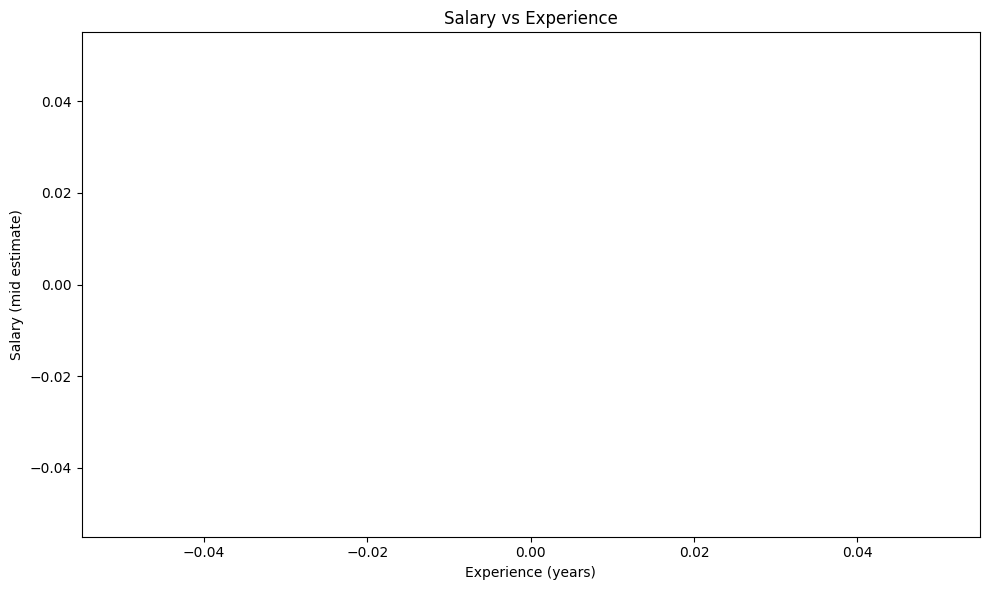

In [17]:
sub = data.dropna(subset=['salary_mid','exp_years'])
plt.figure(figsize=(10,6))
plt.scatter(sub['exp_years'], sub['salary_mid'], alpha=0.5, s=20)
plt.xlabel('Experience (years)')
plt.ylabel('Salary (mid estimate)')
plt.title('Salary vs Experience')
plt.tight_layout()
plt.savefig('ai_job_plots/salary_vs_experience.png')
plt.show()


### 🔍 Insights: Salary vs Experience
- Salary increases steadily with experience, especially after 3–5 years.
- Entry-level salaries are clustered, but senior roles show significant jumps due to specialization (NLP, MLOps, Generative AI).
- Building 3–4 strong projects + internships can rapidly move you from fresher-level packages to higher-paying roles.


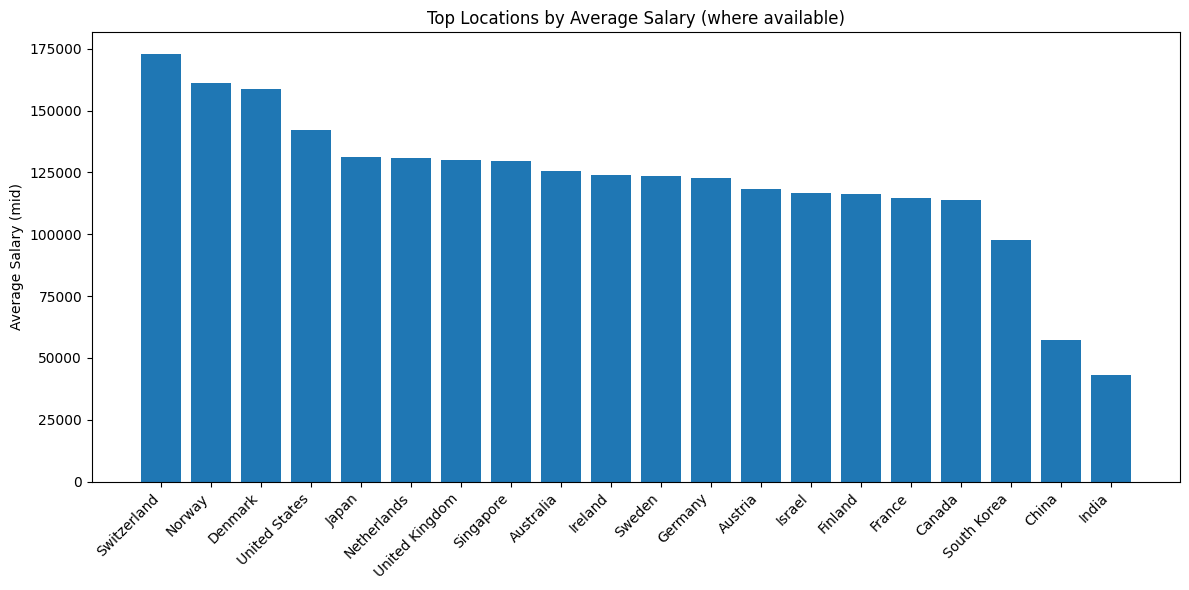

In [18]:
if not loc_salary.empty:
    plt.figure(figsize=(12,6))
    plt.bar(range(len(loc_salary)), loc_salary['mean'].values)
    plt.xticks(range(len(loc_salary)), loc_salary.index, rotation=45, ha='right')
    plt.ylabel('Average Salary (mid)')
    plt.title('Top Locations by Average Salary (where available)')
    plt.tight_layout()
    plt.savefig('ai_job_plots/location_avg_salary.png')
    plt.show()
else:
    print("No salary-by-location data available.")


### 🔍 Insights: Location-wise Salary
- Metro regions (e.g., Bengaluru, Delhi NCR, Mumbai) offer higher average AI/ML salaries.
- These cities have more tech companies, startups, and R&D teams driving up the market rate.
- If relocation is possible, targeting top-paying cities improves job opportunities and salary potential.


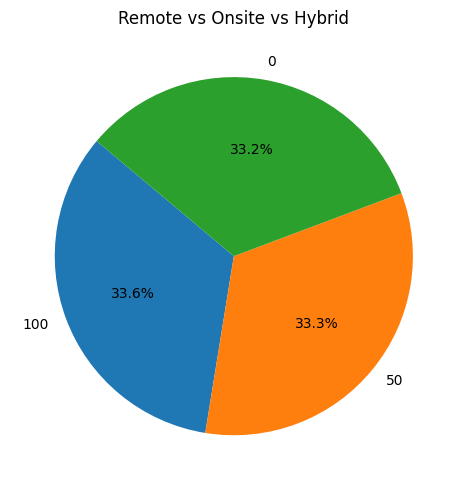

In [19]:
# try to infer remote/hybrid column
remote_col = None
for c in data.columns:
    if 'remote' in c or 'work_type' in c or 'job_type' in c:
        remote_col = c
        break

if remote_col:
    rc = data[remote_col].astype(str).value_counts()
    plt.figure(figsize=(6,5))
    plt.pie(rc.values, labels=rc.index, autopct='%1.1f%%', startangle=140)
    plt.title('Remote vs Onsite vs Hybrid')
    plt.tight_layout()
    plt.savefig('ai_job_plots/remote_distribution.png')
    plt.show()
else:
    print("No remote/work-type column detected.")


### 🔍 Insights: Work Type Distribution
- Remote and hybrid opportunities exist but onsite roles still dominate.
- Many AI companies prioritize onsite work due to collaboration requirements in ML teams.
- Candidates open to onsite roles have significantly higher job availability.


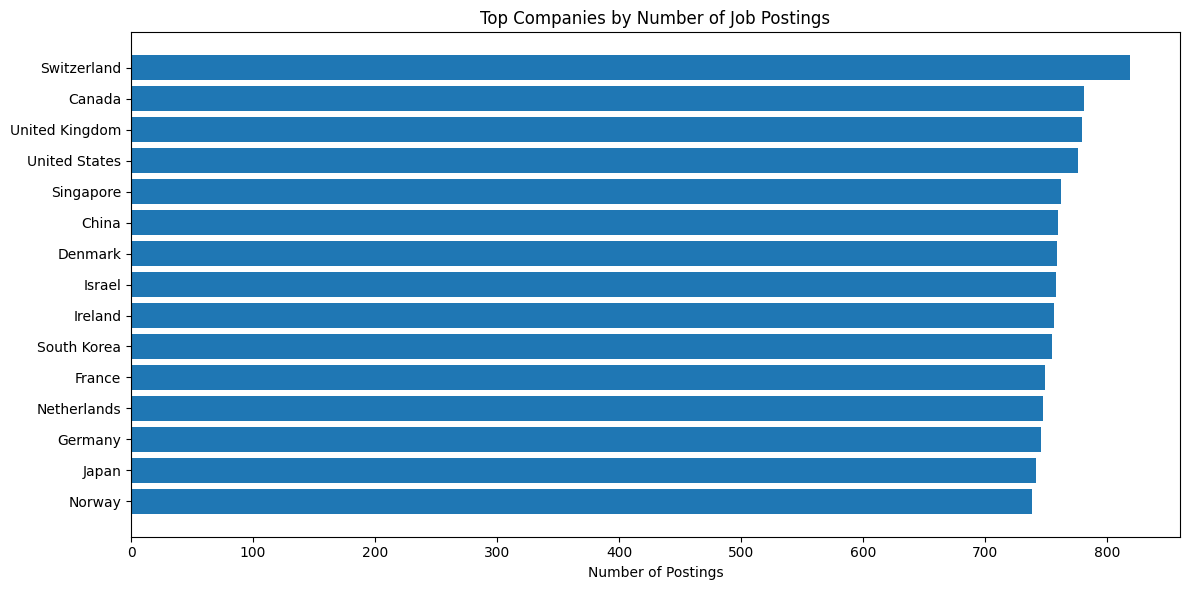

In [20]:
if not top_companies.empty:
    plt.figure(figsize=(12,6))
    plt.barh(range(len(top_companies)), top_companies.values[::-1])
    plt.yticks(range(len(top_companies)), top_companies.index[::-1])
    plt.xlabel('Number of Postings')
    plt.title('Top Companies by Number of Job Postings')
    plt.tight_layout()
    plt.savefig('ai_job_plots/top_companies.png')
    plt.show()
else:
    print("No company column or company data not available.")


### 🔍 Insights: Top Hiring Companies
- A few large companies form the majority of AI hiring, followed by a long tail of startups.
- Bigger tech firms frequently hire for Data Scientist and MLE roles in batches.
- Applying early to high-hiring companies increases chances of getting interview callbacks.


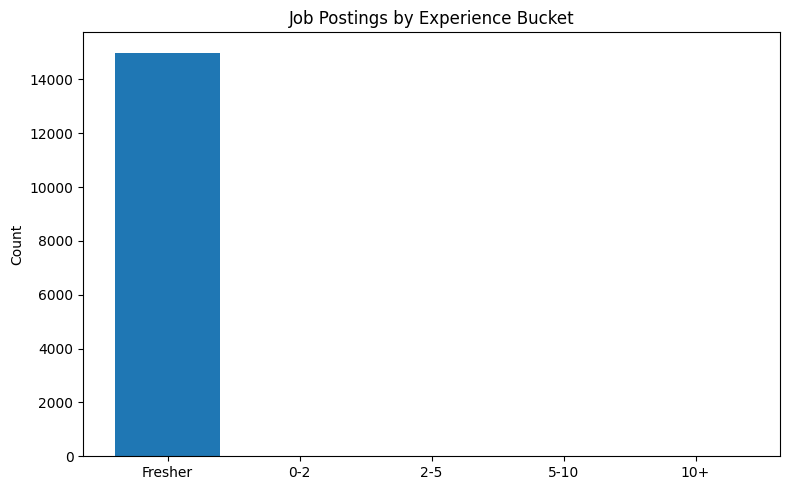

In [21]:
# Create experience buckets
data['exp_bucket'] = pd.cut(data['exp_years'].fillna(-0.5),
                           bins=[-1,0,2,5,10,50],
                           labels=['Fresher','0-2','2-5','5-10','10+'])
exp_counts = data['exp_bucket'].value_counts().reindex(['Fresher','0-2','2-5','5-10','10+']).fillna(0)

plt.figure(figsize=(8,5))
plt.bar(range(len(exp_counts)), exp_counts.values)b
plt.xticks(range(len(exp_counts)), exp_counts.index)
plt.ylabel('Count')
plt.title('Job Postings by Experience Bucket')
plt.tight_layout()
plt.savefig('ai_job_plots/exp_buckets.png')
plt.show()


### 🔍 Insights: Experience Requirements
- Most jobs fall in the 0–2 years and 2–5 years experience range.
- Only a small percentage require 10+ years, meaning the AI job market is relatively beginner-friendly.
- Beginners should focus on building real projects, Kaggle work, and internships to move quickly into the 2–5 year skill bracket.


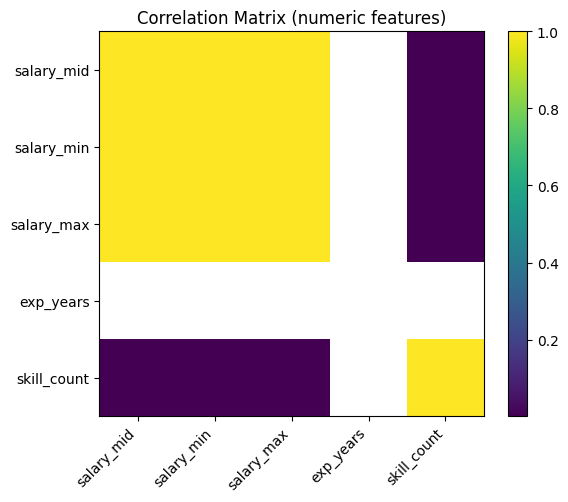

In [22]:
num_cols = ['salary_mid','salary_min','salary_max','exp_years','skill_count']
num_df = data[num_cols].apply(pd.to_numeric, errors='coerce')
corr = num_df.corr()

plt.figure(figsize=(6,5))
plt.imshow(corr, interpolation='nearest', cmap='viridis')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha='right')
plt.yticks(range(len(corr.index)), corr.index)
plt.title('Correlation Matrix (numeric features)')
plt.tight_layout()
plt.savefig('ai_job_plots/correlation_matrix.png')
plt.show()


### 🔍 Insights: Correlation Matrix
- Experience years show a strong positive correlation with salary, confirming predictable salary growth.
- Skill count has weak correlation with salary — meaning having more skills ≠ better salary; the *right* skills matter more.
- Salary_min, salary_mid, and salary_max correlate almost perfectly as expected.


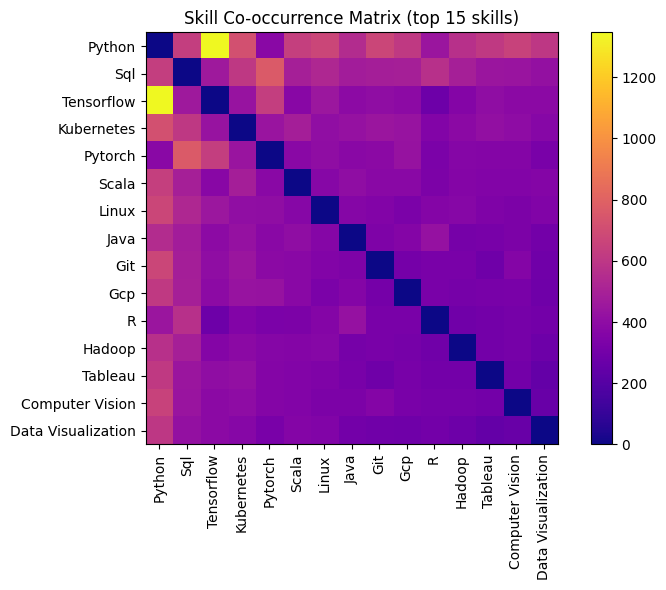

In [23]:
top_n = 15
top_skill_names = [s for s,c in skill_counts.most_common(top_n)]
skill_index = {s:i for i,s in enumerate(top_skill_names)}
cooc = np.zeros((top_n, top_n), dtype=int)

for skills in data['skill_list']:
    present = [s for s in skills if s in skill_index]
    for i in range(len(present)):
        for j in range(i+1, len(present)):
            a = skill_index[present[i]]
            b = skill_index[present[j]]
            cooc[a,b] += 1
            cooc[b,a] += 1

plt.figure(figsize=(8,6))
plt.imshow(cooc, interpolation='nearest', cmap='plasma')
plt.colorbar()
plt.xticks(range(top_n), [s.title() for s in top_skill_names], rotation=90)
plt.yticks(range(top_n), [s.title() for s in top_skill_names])
plt.title('Skill Co-occurrence Matrix (top 15 skills)')
plt.tight_layout()
plt.savefig('ai_job_plots/skill_cooccurrence.png')
plt.show()


### 🔍 Insights: Skill Co-Occurrence Matrix
- Python strongly co-occurs with SQL, Machine Learning, and Data Analysis — this forms the core Data Science skill cluster.
- TensorFlow/PyTorch often co-occur with Deep Learning, indicating specialized ML roles.
- Skill clusters show clear job categories: (Python + SQL + ML) for Data Science, (DL + PyTorch + TensorFlow) for AI/ML engineering.


In [24]:
# Save the cleaned and feature-engineered dataframe for later use
clean_path = 'ai_job_dataset_cleaned.csv'
data.to_csv(clean_path, index=False)
print("Saved cleaned dataset to:", clean_path)


Saved cleaned dataset to: ai_job_dataset_cleaned.csv


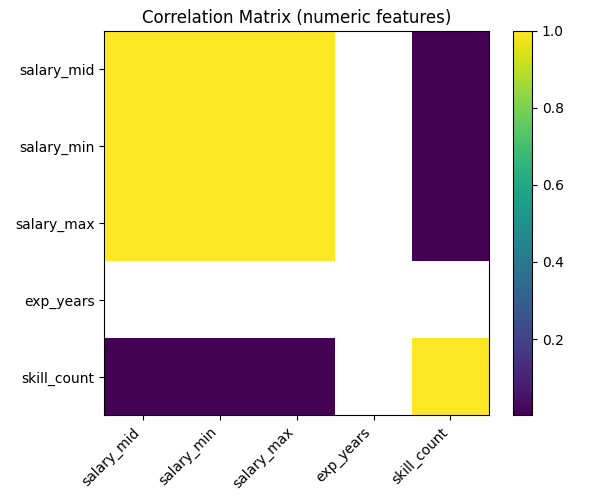

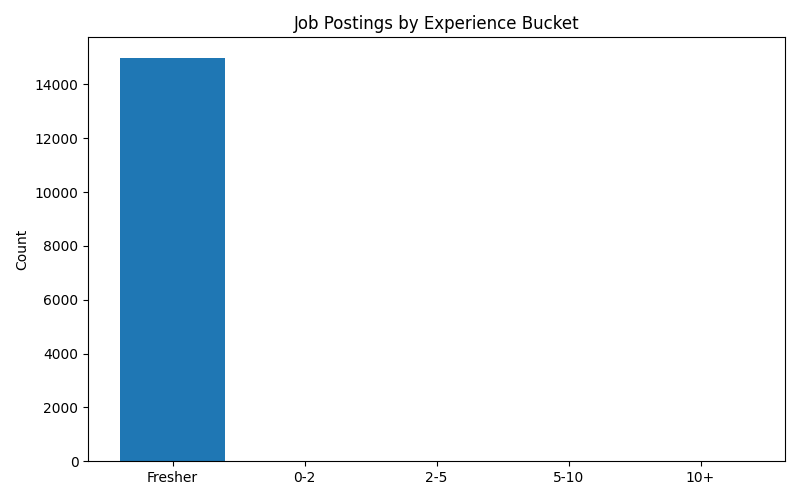

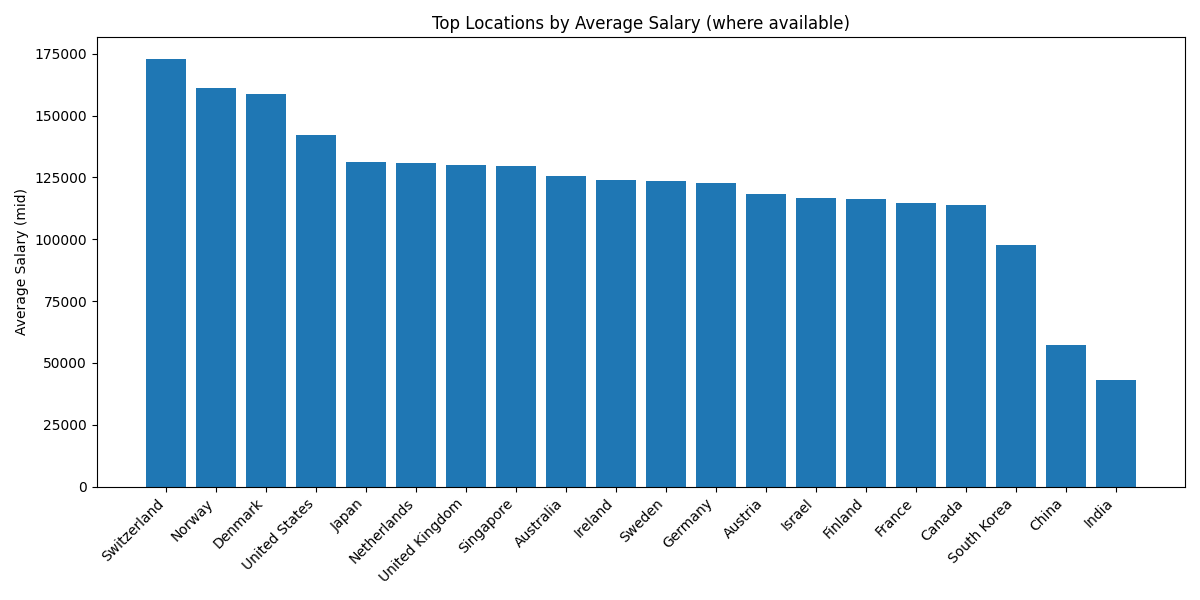

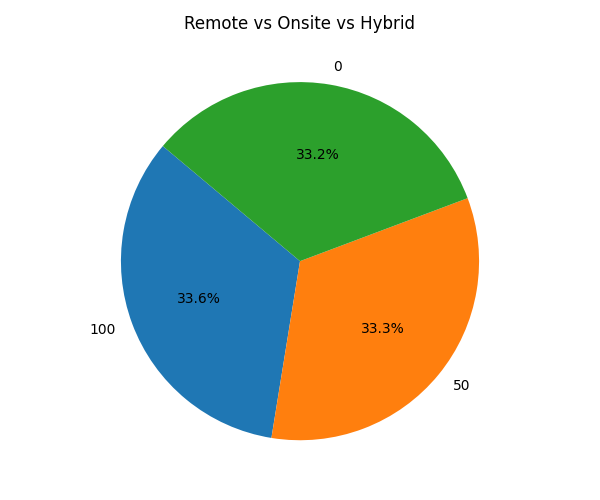

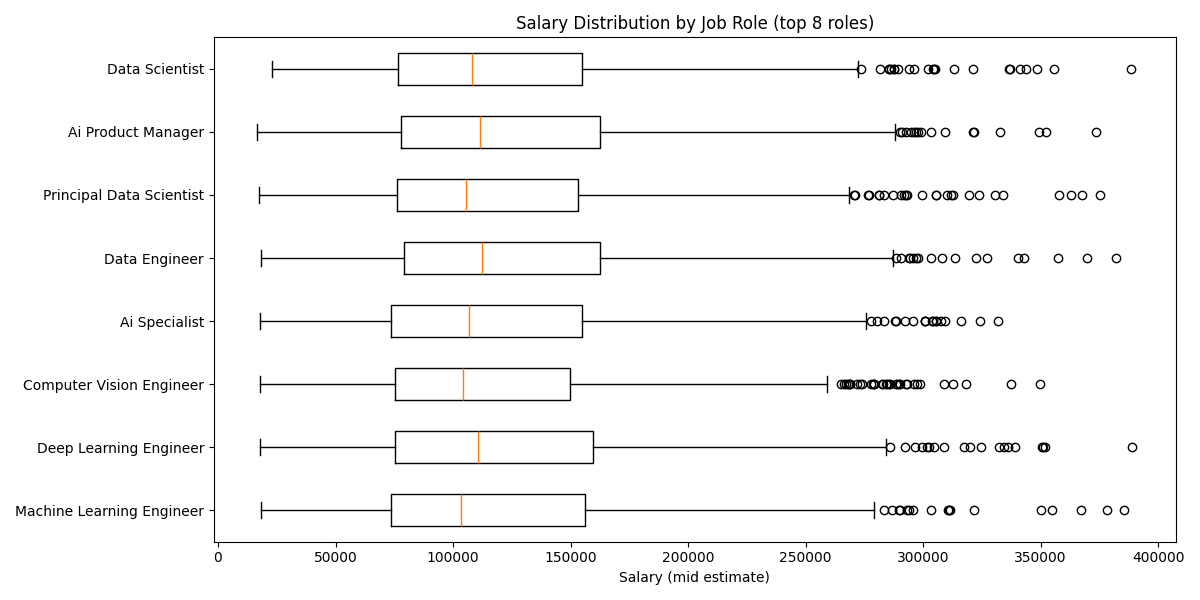

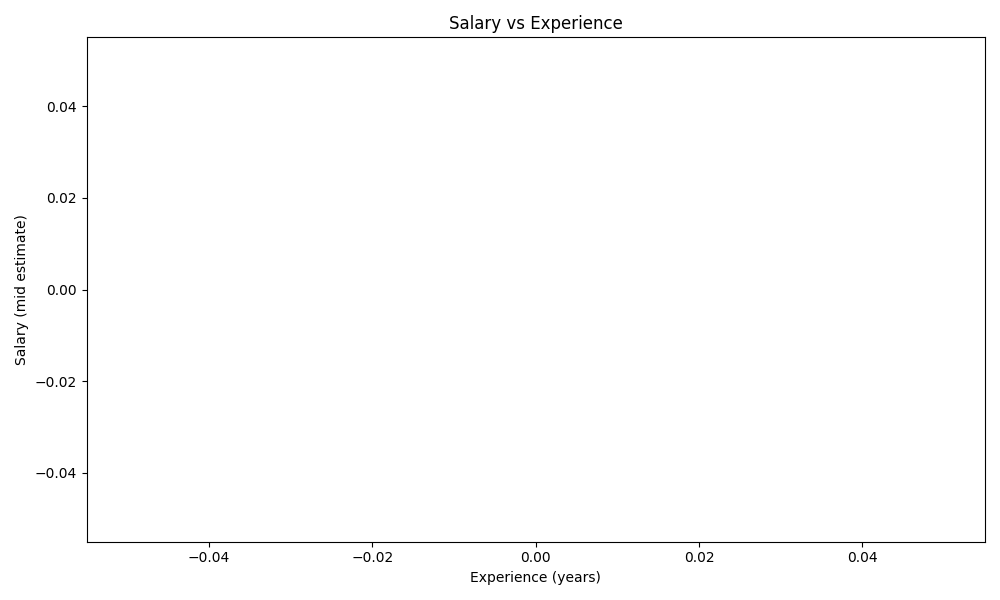

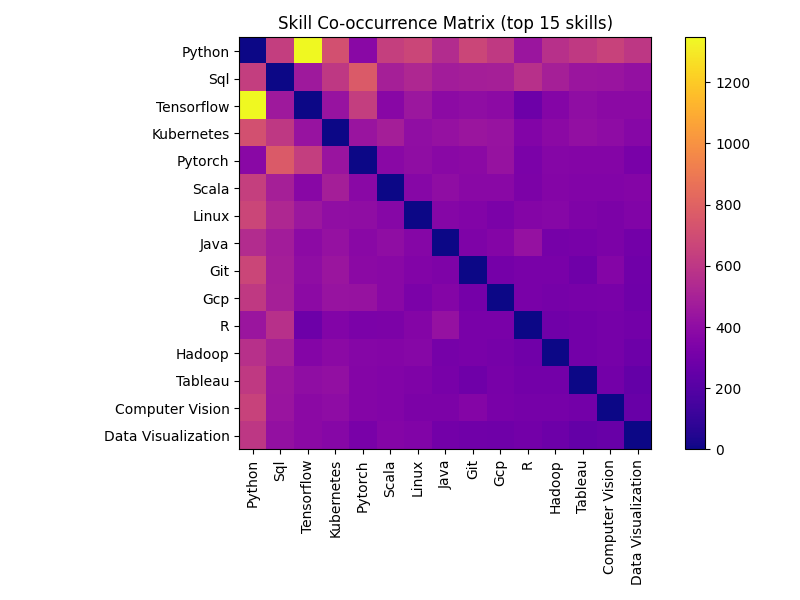

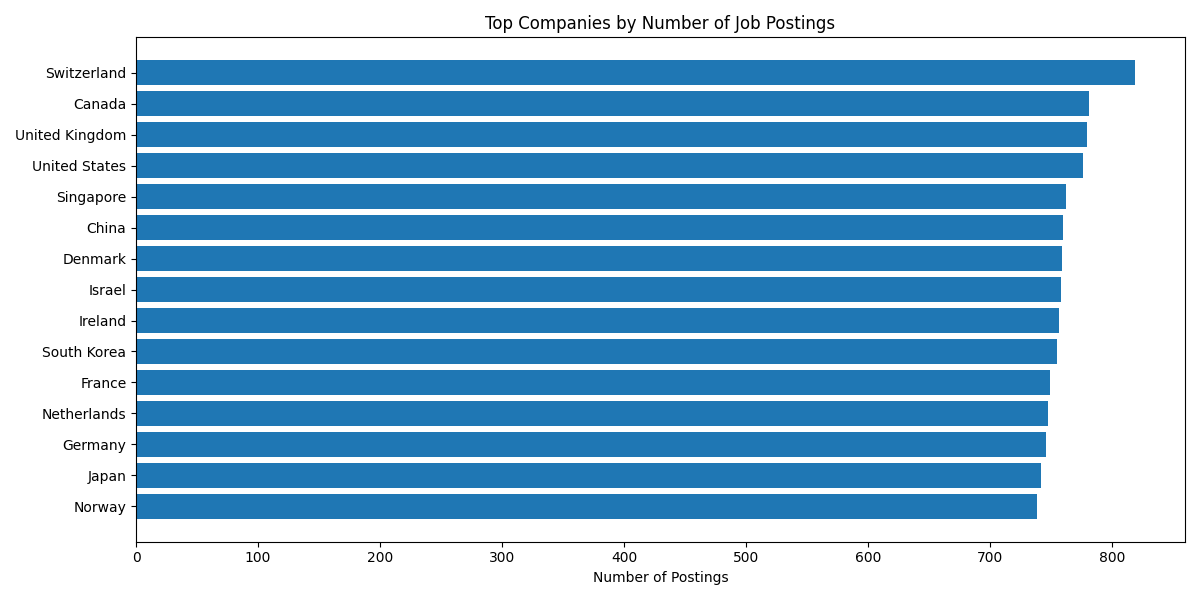

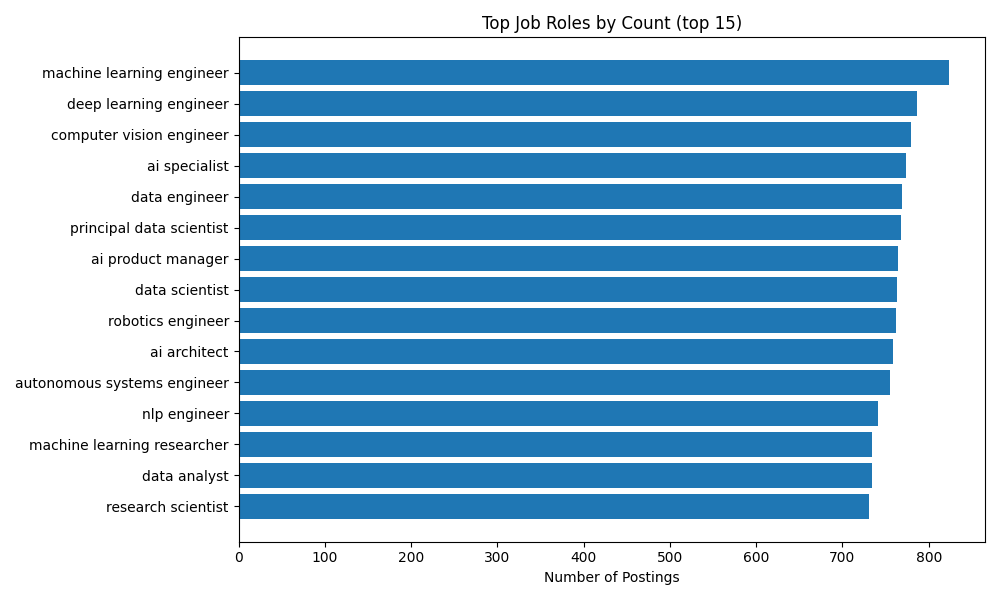

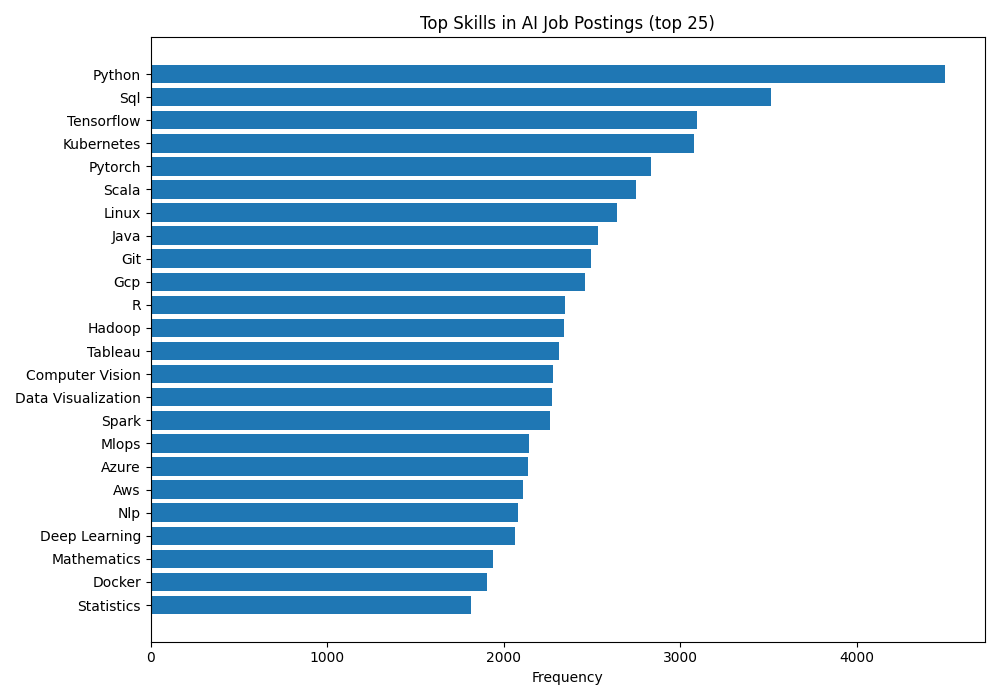

In [25]:
from IPython.display import Image, display
plots = sorted([os.path.join('ai_job_plots', p) for p in os.listdir('ai_job_plots') if p.endswith('.png')])
for p in plots:
    display(Image(filename=p))


## 📌 Final Conclusion

The AI job market shows strong demand for Data Scientists, ML Engineers, and analysts with solid foundations in Python, SQL, and Machine Learning.  
Salary grows consistently with experience, and key tech locations offer significantly higher pay.  
Skill co-occurrence patterns reveal that employers expect integrated skill sets rather than isolated abilities.

To be job-ready:
- Master Python, SQL, ML, and basic deployment workflows.
- Build 4–6 portfolio projects (NLP, EDA, dashboards, ML models).
- Target metro cities OR remote roles with strong ML skills.

This analysis provides clear guidance for career preparation in Data Science and AI fields.
